# Install extra packages

In [1]:
!pip install -q -U tensorflow_addons
!pip install keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 78.4 MB/s eta 0:00:00


# Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!rsync -avzP /content/drive/MyDrive/datasets/kaggling/pfam/pfam.zip . 
!unzip -q pfam.zip

Mounted at /content/drive
sending incremental file list
pfam.zip
    517,047,246 100%   25.43MB/s    0:00:19 (xfr#1, to-chk=0/1)

sent 517,323,336 bytes  received 35 bytes  22,013,760.47 bytes/sec
total size is 517,047,246  speedup is 1.00


# Imports

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dense, GlobalAveragePooling1D, LayerNormalization, Dropout
from tensorflow.keras.models import Model

import tensorflow.keras as keras
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import layers
from functools import partial 

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import seaborn
import os
import gc

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Inspect dataset

In [2]:
data_dirpath = "random_split"
print('Available dataset partitions: ', os.listdir(data_dirpath))

Available dataset partitions:  ['train', 'random_split', 'dev', 'test']


In [3]:
def read_all_shards(partition='dev', data_dir = data_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    
    return pd.concat(shards)

def read_all_data_initial():
  global train, test, dev, all_train_ds_size, all_test_ds_size, all_dev_ds_size

  test = read_all_shards('test')
  dev = read_all_shards('dev')
  train = read_all_shards('train')

  partitions = {'test': test, 'dev': dev, 'train': train}
  for name, df in partitions.items():
      print('Dataset partition "%s" has %d sequences' % (name, len(df)))

  all_train_ds_size = len(train)
  all_test_ds_size = len(test)
  all_dev_ds_size = len(dev)

  train.reset_index(inplace=True, drop=True)
  dev.reset_index(inplace=True, drop=True)
  test.reset_index(inplace=True, drop=True)

read_all_data_initial()

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


In [4]:
def plot_counts(data):

    counter = Counter(data['family_accession'])
    print(f"how many labels : {len(counter)}")
    
    datasetSize = len(data)
    xs = []
    x_labels = []
    ys = []

    t = 0
    cumulative = []

    for i,(x, y) in  enumerate(counter.most_common()):
        xs.append(i)
        x_labels.append(x)
        ys.append(y)
        t += y / datasetSize
        cumulative.append(t)

    plt.figure(figsize=(16 ,6))
    plt.subplot(1, 2, 1)
    plt.plot(xs, ys)
    plt.yscale("log")

    plt.subplot(1, 2, 2)
    plt.plot(xs, cumulative)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    plt.show()
    return cumulative


how many labels : 17929


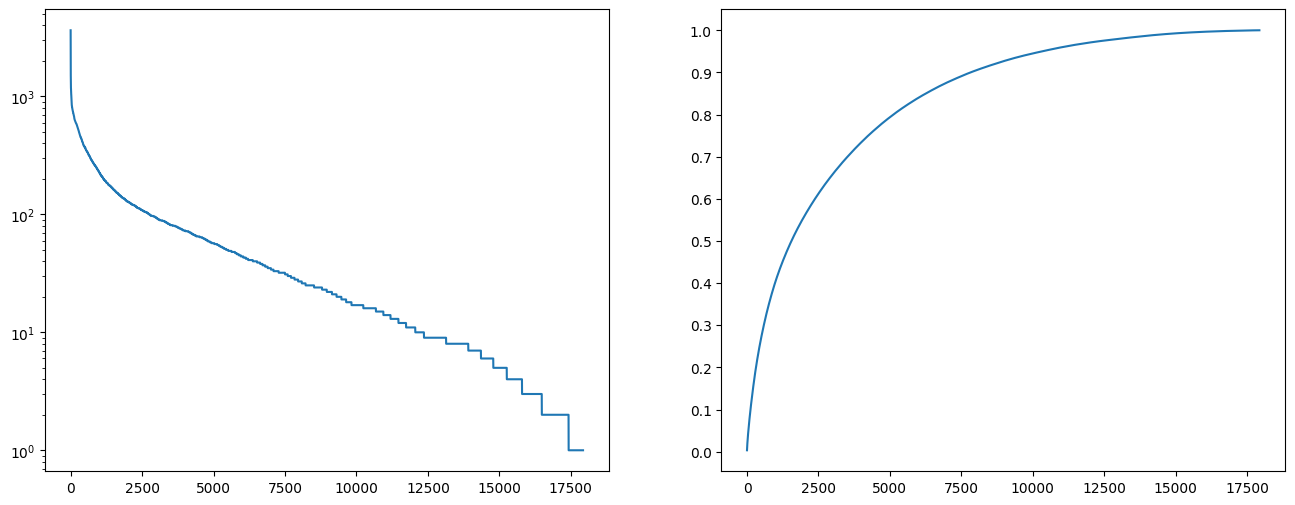

In [5]:
cumulative = plot_counts(train)

In [6]:
n_families_of_interest = 3000

print(f"{n_families_of_interest} classes is {100 * round( cumulative[n_families_of_interest-1],3)} portion of training data")

3000 classes is 65.9 portion of training data


# Create the Dataset

how many labels : 3000


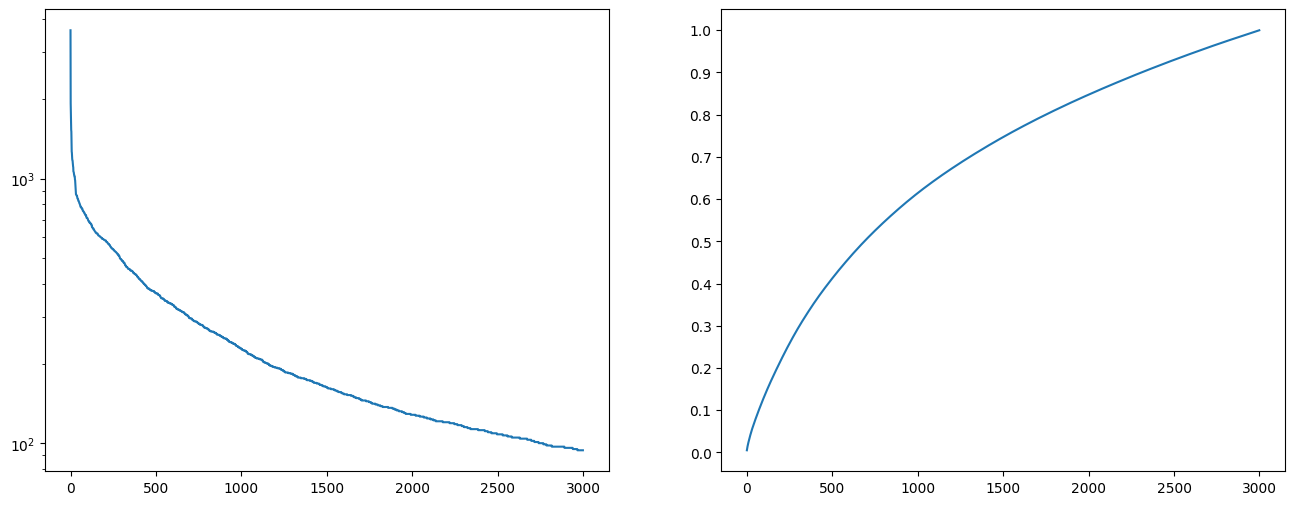

In [7]:
familiesOfInterest = train.family_accession.value_counts()[:n_families_of_interest]

mask = train.family_accession.isin(familiesOfInterest.index.values)
train = train.loc[mask,:]

mask = dev.family_accession.isin(familiesOfInterest.index.values)
dev = dev.loc[mask,:]

mask = test.family_accession.isin(familiesOfInterest.index.values)
test = test.loc[mask,:]

cumulative_split = plot_counts(train)

In [8]:
train_seq = train['sequence']
dev_seq = dev['sequence']
test_seq = test['sequence']

In [9]:
train_sentences = train_seq.apply(lambda seq: [aa for aa in seq])
validation_sentences = dev_seq.apply(lambda seq: [aa for aa in seq])
test_sentences = test_seq.apply(lambda seq: [aa for aa in seq])

In [10]:
train_labels = train['family_accession'].apply(lambda x: x.split('.')[0])
validation_labels = dev['family_accession'].apply(lambda x: x.split('.')[0])
test_labels = test['family_accession'].apply(lambda x: x.split('.')[0])

label_tokenizer = Tokenizer(oov_token = -1)
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

training_label_seq = training_label_seq-1
validation_label_seq = validation_label_seq-1
test_label_seq = test_label_seq-1

In [11]:
vocab_size = 25
embedding_dim = vocab_size
max_length = 512
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_portion = .8

tokenizer = Tokenizer(oov_token=oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'l': 2, 'a': 3, 'g': 4, 'v': 5, 'e': 6, 'i': 7, 's': 8, 'r': 9, 'd': 10, 't': 11, 'k': 12, 'p': 13, 'f': 14, 'n': 15, 'q': 16, 'y': 17, 'm': 18, 'h': 19, 'c': 20, 'w': 21, 'x': 22, 'u': 23, 'b': 24, 'o': 25}


In [12]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sequences[0])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)
print(train_padded[0])

[11, 2, 21, 12, 17, 5, 9, 11, 13, 4, 9, 7, 11, 17, 10, 6, 11, 9, 2, 3, 19, 2, 19, 13, 9, 3, 13, 4, 21, 7, 6, 4, 2, 8, 5, 9, 3, 2, 4, 6, 13, 5, 4, 3, 4, 16, 6, 2, 3, 6, 2, 17, 3, 13, 6, 7, 2, 8, 3, 16, 5, 10, 14, 2, 2, 3, 2, 3, 13, 16, 13, 6, 4, 5, 3, 9, 5, 9, 5, 10, 16, 3, 9, 15, 7, 2, 9, 2, 2, 10, 5, 13, 6, 3, 10, 7, 9, 3, 7, 6, 9, 8, 4, 6, 11, 9, 16, 11, 5, 13, 5, 2, 3, 13, 7, 10, 4, 5, 5, 11, 6, 18, 12, 3, 9, 6, 4, 18, 17, 5, 11, 3, 3, 10, 3, 18, 17, 11, 7, 3, 10, 2, 8, 9, 5, 21, 5, 2, 3, 10, 5, 14, 6, 19, 16, 7, 10, 21, 7, 3, 13, 4, 16, 4, 3, 6, 7, 9, 5, 13, 3, 17, 13, 4, 9, 8, 21, 6, 4, 6, 5, 10, 17, 2, 17, 13, 3, 2, 10, 13, 16, 11, 9, 11, 2, 9, 5, 9, 2, 5, 14, 10, 15, 13, 6, 4, 2, 2, 9, 13, 15, 18, 14, 3]
[11  2 21 12 17  5  9 11 13  4  9  7 11 17 10  6 11  9  2  3 19  2 19 13
  9  3 13  4 21  7  6  4  2  8  5  9  3  2  4  6 13  5  4  3  4 16  6  2
  3  6  2 17  3 13  6  7  2  8  3 16  5 10 14  2  2  3  2  3 13 16 13  6
  4  5  3  9  5  9  5 10 16  3  9 15  7  2  9  2  2 10  5 13

In [13]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type)

In [14]:
print(train_padded.shape)
print(validation_padded.shape)
print(test_padded.shape)
print(train_padded[0])

(715645, 512)
(87755, 512)
(87755, 512)
[11  2 21 12 17  5  9 11 13  4  9  7 11 17 10  6 11  9  2  3 19  2 19 13
  9  3 13  4 21  7  6  4  2  8  5  9  3  2  4  6 13  5  4  3  4 16  6  2
  3  6  2 17  3 13  6  7  2  8  3 16  5 10 14  2  2  3  2  3 13 16 13  6
  4  5  3  9  5  9  5 10 16  3  9 15  7  2  9  2  2 10  5 13  6  3 10  7
  9  3  7  6  9  8  4  6 11  9 16 11  5 13  5  2  3 13  7 10  4  5  5 11
  6 18 12  3  9  6  4 18 17  5 11  3  3 10  3 18 17 11  7  3 10  2  8  9
  5 21  5  2  3 10  5 14  6 19 16  7 10 21  7  3 13  4 16  4  3  6  7  9
  5 13  3 17 13  4  9  8 21  6  4  6  5 10 17  2 17 13  3  2 10 13 16 11
  9 11  2  9  5  9  2  5 14 10 15 13  6  4  2  2  9 13 15 18 14  3  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  

# Keras util functions

In [15]:
def plot_history(data):
  plt.plot(data['loss'], label="loss")
  plt.plot(data['val_loss'], label="val_loss")
  plt.legend()
  plt.show()

  plt.plot(data['accuracy'], label="accuracy")
  plt.plot(data['val_accuracy'], label="val_accuracy")
  plt.legend()
  plt.show()

def train_network(get_model, save_path, epochs=25, INIT_LR=1e-4, MAX_LR=1e-3, BATCH_SIZE=32):
  steps_per_epoch = len(train_sequences) // BATCH_SIZE
  clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
      maximal_learning_rate=MAX_LR,
      scale_fn=lambda x: 1/(2.**(x-1)),
      step_size=2 * steps_per_epoch
  )

  es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=5)
  save_model_cb = tf.keras.callbacks.ModelCheckpoint(save_path, monitor = "accuracy", verbose= 1, save_best_only = True) 

  model = get_model()
  optimizer = tf.keras.optimizers.Adam(clr)
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  model.summary()

  history = model.fit(train_padded, training_label_seq, epochs=epochs, validation_data=(validation_padded, validation_label_seq), 
                      callbacks = [es_cb , save_model_cb])
  
  data = history.history
  plot_history(data)
  return history

# ProtCNN

## Architecture

In [ ]:
def residual_block(x, dil, filters, ks=3):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(x)
    conv1 = tf.keras.layers.Conv1D(filters, ks, dilation_rate=dil, padding="same")(x)
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, ks, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    return x


def getProtCNN(numclass, residuals_ks=3, residuals_filters=64):
    input_x = tf.keras.layers.Input(shape=(512, ))
    x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
    x = tf.keras.layers.Permute(dims=[2, 1])(x)
    x = tf.keras.layers.Conv1D(64, 8, padding="same")(x)
    x = residual_block(x, 1, residuals_filters, ks=residuals_ks)
    x = residual_block(x, 2, residuals_filters, ks=residuals_ks)
    x = tf.keras.layers.Permute(dims=[2, 1])(x)
    x = tf.keras.layers.Conv1D(64, 3, padding="same")(x)
    x = residual_block(x, 1, residuals_filters, ks=residuals_ks)
    x = residual_block(x, 2, residuals_filters, ks=residuals_ks)
    x = tf.keras.layers.Lambda(lambda x: K.expand_dims(x, -1))(x) #will not compile if not defined as lambda
    x = tf.keras.layers.Conv2D(32, (4,4), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(8, (8,8), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D((64,64))(x)
    #x = tf.keras.layers.Conv1D(8, 8, padding="same")(x)
    #x = tf.keras.layers.MaxPooling1D(64)(x)
    x = tf.keras.layers.Flatten()(x)
    out = tf.keras.layers.Dense(numclass+1, activation="softmax")(x)

    model = tf.keras.Model(inputs=input_x, outputs=out)
    return model

## Experiment 1

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 512, 25)      625         ['input_5[0][0]']                
                                                                                                  
 permute_8 (Permute)            (None, 25, 512)      0           ['embedding_4[0][0]']            
                                                                                                  
 conv1d_40 (Conv1D)             (None, 25, 64)       262208      ['permute_8[0][0]']              
                                                                                            

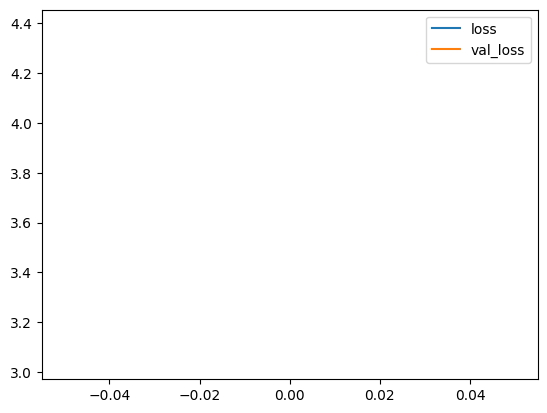

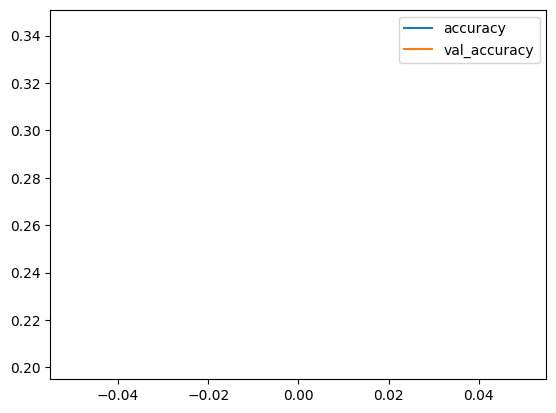

In [ ]:
model = partial(partial(getProtCNN, n_families_of_interest))
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "protCNN_asd.h5"), epochs=1)

## Experiment 2

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 512, 25)      625         ['input_8[0][0]']                
                                                                                                  
 permute_14 (Permute)           (None, 25, 512)      0           ['embedding_7[0][0]']            
                                                                                                  
 conv1d_70 (Conv1D)             (None, 25, 64)       262208      ['permute_14[0][0]']             
                                                                                            

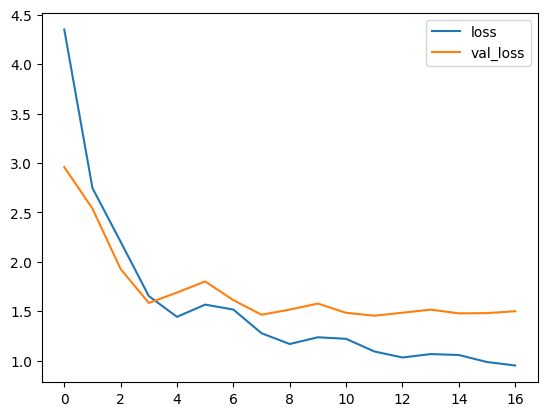

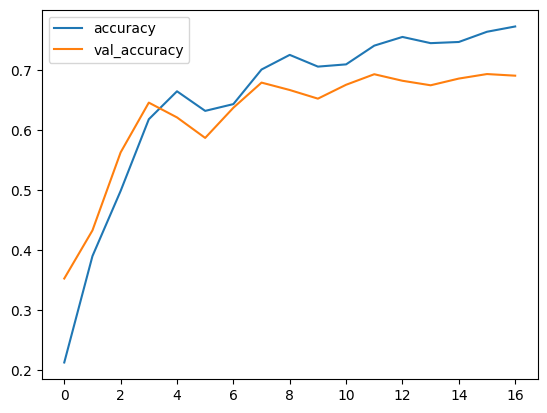

In [ ]:
model = partial(partial(getProtCNN, numclass=n_families_of_interest, residuals_ks=5))
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "protCNN_ks=5.h5"), epochs=25)

## Experiment 3

In [ ]:
model = partial(partial(getProtCNN, numclass=n_families_of_interest, residuals_ks=7, residuals_filters=128))
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "protCNN_ks=8_rs=128.h5"), epochs=25)

ValueError: ignored

# Simple Bidirectional LSTM classification


## Model

In [35]:
def LSTM_Model(numclass):
    model = tf.keras.models.Sequential([
            layers.Input(shape=(512, )),
            layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.GlobalMaxPool1D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(numclass+1, activation="softmax")
        ]
    )
    return model

## Experiment 1

In [36]:
model = partial(LSTM_Model, numclass=n_families_of_interest)
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "bidirecctional1.h5"), epochs=25)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 512, 25)           625       
                                                                 
 bidirectional_3 (Bidirectio  (None, 512, 128)         46080     
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 3001)              387129    
                                                                 
Total params: 450,346
Trainable params: 449,721
Non-tr

KeyboardInterrupt: ignored

# Transformer 

## Simple transformer

### Architecture

In [43]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


def plain_transformer_model(numclass, num_heads=4, ff_dim=512, blocks=3):
  inputs = layers.Input(shape=(512,))
  embedding_layer = TokenAndPositionEmbedding(512, 25, 25)
  x = embedding_layer(inputs)

  for b in range(blocks):
    x = TransformerBlock(25, num_heads, ff_dim)(x)
  x = layers.GlobalAveragePooling1D()(x)
  #x = layers.Dropout(0.1)(x)
  x = layers.Dense(128, activation="relu")(x)
  #x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(numclass+1, activation="softmax")(x)

  # Model
  return tf.keras.models.Model(inputs=inputs, outputs=outputs)



### Experiment 1

In [44]:
model = partial(plain_transformer_model, numclass=n_families_of_interest, num_heads=4,ff_dim=256, blocks=1)
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "transformer.h5"), epochs=25)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 512)]             0         
                                                                 
 token_and_position_embeddin  (None, 512, 25)          13425     
 g_11 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_17 (Trans  (None, 512, 25)          23506     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_10  (None, 25)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_54 (Dense)            (None, 128)               3328

KeyboardInterrupt: ignored

## Fnet Model

### Architecture

In [43]:
import keras_nlp
import tensorflow.keras as keras

VOCAB_SIZE=25
MAX_SEQUENCE_LENGTH = 512
EMBED_DIM = 25
INTERMEDIATE_DIM = 128

def get_fnet_model(numclass):

  input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")

  x = keras_nlp.layers.TokenAndPositionEmbedding(
      vocabulary_size=VOCAB_SIZE,
      sequence_length=MAX_SEQUENCE_LENGTH,
      embedding_dim=EMBED_DIM,
      mask_zero=True,
  )(input_ids)

  x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
  x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
  x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)


  x = keras.layers.GlobalAveragePooling1D()(x)
  x = keras.layers.Dropout(0.1)(x)
  outputs = layers.Dense(numclass+1, activation="softmax")(x)

  fnet_classifier = keras.Model(input_ids, outputs, name="fnet_classifier")
  return fnet_classifier

n_families_of_interest

3000

### Experiments

In [ ]:
model = partial(get_fnet_model, numclass=n_families_of_interest)
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "bidirecctional1.h5"), epochs=25)

Model: "fnet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, None)]            0         
                                                                 
 token_and_position_embeddin  (None, None, 25)         13425     
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 f_net_encoder_6 (FNetEncode  (None, None, 25)         6653      
 r)                                                              
                                                                 
 f_net_encoder_7 (FNetEncode  (None, None, 25)         6653      
 r)                                                              
                                                                 
 f_net_encoder_8 (FNetEncode  (None, None, 25)     

22362/22364 [============================>.] - ETA: 0s - loss: 5.7009 - accuracy: 0.1047
Epoch 1: accuracy improved from -inf to 0.10475, saving model to /content/drive/MyDrive/datasets/kaggling/pfam/models/bidirecctional1.h5
22364/22364 [==============================] - 297s 13ms/step - loss: 5.7007 - accuracy: 0.1048 - val_loss: 3.3057 - val_accuracy: 0.2918
Epoch 2/25
22362/22364 [============================>.] - ETA: 0s - loss: 2.9024 - accuracy: 0.3542
Epoch 2: accuracy improved from 0.10475 to 0.35422, saving model to /content/drive/MyDrive/datasets/kaggling/pfam/models/bidirecctional1.h5
22364/22364 [==============================] - 291s 13ms/step - loss: 2.9023 - accuracy: 0.3542 - val_loss: 2.4167 - val_accuracy: 0.4413
Epoch 3/25
22361/22364 [============================>.] - ETA: 0s - loss: 2.3791 - accuracy: 0.4499
Epoch 3: accuracy improved from 0.35422 to 0.44988, saving model to /content/drive/MyDrive/datasets/kaggling/pfam/models/bidirecctional1.h5
22364/22364 [=====

## Switch model

In [21]:
embed_dim = 25  # Embedding size for each token.
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network.
num_experts = 10  # Number of experts used in the Switch Transformer.
batch_size = 32  # Batch size.
dropout_rate = 0.25  # Dropout rate.
num_tokens_per_example = 512
num_tokens_per_batch = (
    batch_size * num_tokens_per_example
)  # Total number of tokens per batch.
print(f"Number of tokens per batch: {num_tokens_per_batch}")


Number of tokens per batch: 16384


In [22]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def create_feedforward_network(ff_dim, name=None):
    return keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(ff_dim)], name=name
    )

def load_balanced_loss(router_probs, expert_mask):
    # router_probs [tokens_per_batch, num_experts] is the probability assigned for
    # each expert per token. expert_mask [tokens_per_batch, num_experts] contains
    # the expert with the highest router probability in one−hot format.

    num_experts = tf.shape(expert_mask)[-1]
    # Get the fraction of tokens routed to each expert.
    # density is a vector of length num experts that sums to 1.
    density = tf.reduce_mean(expert_mask, axis=0)
    # Get fraction of probability mass assigned to each expert from the router
    # across all tokens. density_proxy is a vector of length num experts that sums to 1.
    density_proxy = tf.reduce_mean(router_probs, axis=0)
    # Want both vectors to have uniform allocation (1/num experts) across all
    # num_expert elements. The two vectors will be pushed towards uniform allocation
    # when the dot product is minimized.
    loss = tf.reduce_mean(density_proxy * density) * tf.cast(
        (num_experts ** 2), tf.dtypes.float32
    )
    return loss


class Router(layers.Layer):
    def __init__(self, num_experts, expert_capacity):
        self.num_experts = num_experts
        self.route = layers.Dense(units=num_experts)
        self.expert_capacity = expert_capacity
        super().__init__()

    def call(self, inputs, training=False):
        # inputs shape: [tokens_per_batch, embed_dim]
        # router_logits shape: [tokens_per_batch, num_experts]
        router_logits = self.route(inputs)

        if training:
            # Add noise for exploration across experts.
            router_logits += tf.random.uniform(
                shape=router_logits.shape, minval=0.9, maxval=1.1
            )
        # Probabilities for each token of what expert it should be sent to.
        router_probs = keras.activations.softmax(router_logits, axis=-1)
        # Get the top−1 expert for each token. expert_gate is the top−1 probability
        # from the router for each token. expert_index is what expert each token
        # is going to be routed to.
        expert_gate, expert_index = tf.math.top_k(router_probs, k=1)
        # expert_mask shape: [tokens_per_batch, num_experts]
        expert_mask = tf.one_hot(expert_index, depth=self.num_experts)
        # Compute load balancing loss.
        aux_loss = load_balanced_loss(router_probs, expert_mask)
        self.add_loss(aux_loss)
        # Experts have a fixed capacity, ensure we do not exceed it. Construct
        # the batch indices, to each expert, with position in expert make sure that
        # not more that expert capacity examples can be routed to each expert.
        position_in_expert = tf.cast(
            tf.math.cumsum(expert_mask, axis=0) * expert_mask, tf.dtypes.int32
        )
        # Keep only tokens that fit within expert capacity.
        expert_mask *= tf.cast(
            tf.math.less(
                tf.cast(position_in_expert, tf.dtypes.int32), self.expert_capacity
            ),
            tf.dtypes.float32,
        )
        expert_mask_flat = tf.reduce_sum(expert_mask, axis=-1)
        # Mask out the experts that have overflowed the expert capacity.
        expert_gate *= expert_mask_flat
        # Combine expert outputs and scaling with router probability.
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        combined_tensor = tf.expand_dims(
            expert_gate
            * expert_mask_flat
            * tf.squeeze(tf.one_hot(expert_index, depth=self.num_experts), 1),
            -1,
        ) * tf.squeeze(tf.one_hot(position_in_expert, depth=self.expert_capacity), 1)
        # Create binary dispatch_tensor [tokens_per_batch, num_experts, expert_capacity]
        # that is 1 if the token gets routed to the corresponding expert.
        dispatch_tensor = tf.cast(combined_tensor, tf.dtypes.float32)

        return dispatch_tensor, combined_tensor

class Switch(layers.Layer):
    def __init__(self, num_experts, embed_dim, num_tokens_per_batch, capacity_factor=1):
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.experts = [
            create_feedforward_network(embed_dim) for _ in range(num_experts)
        ]

        self.expert_capacity = num_tokens_per_batch // self.num_experts
        self.router = Router(self.num_experts, self.expert_capacity)
        super().__init__()

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        num_tokens_per_example = tf.shape(inputs)[1]

        # inputs shape: [num_tokens_per_batch, embed_dim]
        inputs = tf.reshape(inputs, [num_tokens_per_batch, self.embed_dim])
        # dispatch_tensor shape: [expert_capacity, num_experts, tokens_per_batch]
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        dispatch_tensor, combine_tensor = self.router(inputs)
        # expert_inputs shape: [num_experts, expert_capacity, embed_dim]
        expert_inputs = tf.einsum("ab,acd->cdb", inputs, dispatch_tensor)
        expert_inputs = tf.reshape(
            expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim]
        )
        # Dispatch to experts
        expert_input_list = tf.unstack(expert_inputs, axis=0)
        expert_output_list = [
            self.experts[idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]
        # expert_outputs shape: [expert_capacity, num_experts, embed_dim]
        expert_outputs = tf.stack(expert_output_list, axis=1)
        # expert_outputs_combined shape: [tokens_per_batch, embed_dim]
        expert_outputs_combined = tf.einsum(
            "abc,xba->xc", expert_outputs, combine_tensor
        )
        # output shape: [batch_size, num_tokens_per_example, embed_dim]
        outputs = tf.reshape(
            expert_outputs_combined,
            [batch_size, num_tokens_per_example, self.embed_dim],
        )
        return outputs

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ffn, dropout_rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # The ffn can be either a standard feedforward network or a switch
        # layer with a Mixture of Experts.
        self.ffn = ffn
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_switch_transformer(numclass):
    switch = Switch(num_experts, embed_dim, num_tokens_per_batch)
    transformer_block = TransformerBlock(ff_dim, num_heads, switch)

    inputs = layers.Input(shape=(num_tokens_per_example,))
    embedding_layer = TokenAndPositionEmbedding(
        num_tokens_per_example, vocab_size, embed_dim
    )
    x = embedding_layer(inputs)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(numclass+1, activation="softmax")(x)

    classifier = keras.Model(inputs=inputs, outputs=outputs)
    return classifier


### Experiments

In [23]:
model = partial(create_switch_transformer, numclass=n_families_of_interest)
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "switch_transformer.h5"), epochs=25)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 token_and_position_embeddin  (None, 512, 25)          13425     
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (32, 512, 25)            19977     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (32, 25)                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (32, 25)                  0   

KeyboardInterrupt: ignored